# Wind Energy Forecaseting

The goal of this notebook is to perform the energy forecasting for the ["Global Energy Forecasting Competition 2012" ](https://www.kaggle.com/c/GEF2012-wind-forecasting).

"This competition is deveoped to mimic the operation 48-hour ahead prediction of hourly power generation. This is performed for 7 wind farms. The data being used for this competition are historical measurements and additional wind forecast information (48-hour ahead predictions of wind speed and direction at the sites). The data is available for period ranging from the 1st hour of 2009/7/1 to the 12th hour of 2012/6/28." [ref](https://www.kaggle.com/c/GEF2012-wind-forecasting)

I followed the following [approach](https://github.com/lucaseustaquio/gefcom-2012-wind-track/blob/master/doc/WindForecast_Leustagos.pdf).


### Package Import

In [517]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
sns.set(style='whitegrid', context='notebook')

### Data Import and Organizing

We are going to first import the power dataset. It will read the train dataset and generate the following columns:

- datetime index
- wind power
- hour
- month
- year
- farm number

In [328]:
energy = pd.read_csv('train.csv')

energy['hour'] = energy['date'].apply(lambda x: str(x)[-2:])
energy['month'] = energy['date'].apply(lambda x: str(x)[4:6])
energy['year'] = energy['date'].apply(lambda x: str(x)[:4])
energy.date = pd.to_datetime(energy.date, format='%Y%m%d%H', errors='ignore')


energy = pd.melt(frame = energy, id_vars =['date','hour','month', 'year'] ,value_vars =['wp1','wp2','wp3','wp4','wp5','wp6','wp7'], var_name = 'farm', value_name='power' )
energy.farm = energy.farm.apply(lambda x: int(x[2:]))
energy.set_index('date', inplace=True)
# we generate a datetime series from the data

In [329]:
energy.describe()

,farm,power
count,131299.000000,131299.000000
mean,4.000000,0.284145
std,2.000008,0.289788
min,1.000000,0.000000
25%,2.000000,0.040000
50%,4.000000,0.178000
75%,6.000000,0.455000
max,7.000000,0.992000


In [330]:
energy.describe(include = ['O'])

,hour,month,year
count,131299,131299,131299
unique,24,12,4
top,06,08,2010
freq,5474,12684,61320


The following demonstrates the mean power generation over several years for all farms.

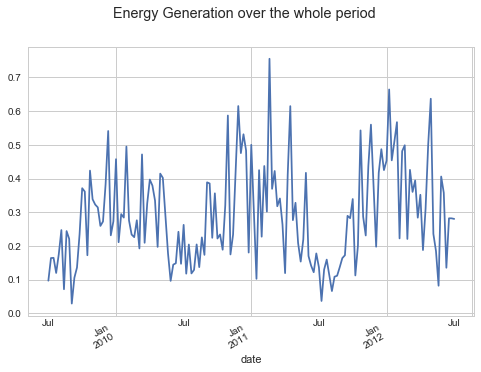

In [331]:
energy['power'].resample('W').mean().plot(title = 'Energy Generation over the whole period' ,subplots=True)
plt.show()

## Forecast data
First let's get the datetime of the prediction time and the predicted time and also the farm number into the data set.

In [332]:
pattern = 'windforecasts*.csv'
csv_files = glob.glob(pattern)
forecast = list()
for indx, file in enumerate(csv_files):
    temp_df = pd.read_csv(file)
    temp_df ['farm'] = indx + 1
    temp_df ['turn'] = temp_df.date.apply(lambda x: str(x)[-2:])
    temp_df['date'] = pd.to_datetime(temp_df.date, format='%Y%m%d%H')
    temp_df.rename(columns = {'date':'start', 'hors':'dist'}, inplace= True)
    temp_df['date'] = temp_df.start + pd.to_timedelta(temp_df.dist, unit='h')
    temp_df.set_index('date', inplace=True)
    temp_df['angle'] = 180*np.arctan(temp_df.v/temp_df.u)
    temp_df['wd_cut'] = pd.cut(temp_df['wd'],bins = 8)
    temp_df['w3p'] = temp_df.ws**3
    forecast.append(temp_df)
    


Now, we will add the set parameter which is going to be used for the cross validation.

In [333]:
group = 1
groups = []
for i in range(forecast[0].shape[0]):
    groups.append(group)
    flag = (i+1)%(84*4)
    if flag == 0:
        group += 1
    
for df in forecast:
    df['set'] = groups
    
single_forecast = pd.concat(forecast)
single_forecast.head()

,start,dist,u,v,ws,wd,farm,turn,angle,wd_cut,w3p,set
date,,,,,,,,,,,,
2009-07-01 01:00:00,2009-07-01,1,2.34,-0.79,2.47,108.68,1,00,-58.606518,"(90.012, 135.009]",15.069223,1
2009-07-01 02:00:00,2009-07-01,2,2.18,-0.99,2.40,114.31,1,00,-76.730730,"(90.012, 135.009]",13.824000,1
2009-07-01 03:00:00,2009-07-01,3,2.20,-1.21,2.51,118.71,1,00,-90.511778,"(90.012, 135.009]",15.813251,1
2009-07-01 04:00:00,2009-07-01,4,2.35,-1.40,2.73,120.86,1,00,-96.711249,"(90.012, 135.009]",20.346417,1
2009-07-01 05:00:00,2009-07-01,5,2.53,-1.47,2.93,120.13,1,00,-94.743438,"(90.012, 135.009]",25.153757,1


### Joining Feature Set

We will join the two data sets and look at their correlations.


In [334]:
whole_data = pd.merge(single_forecast.reset_index(), energy.reset_index(),
                      how = 'left', on = ['date','farm'])
#whole_data.drop(axis=1, columns = ['date', 'start'],inplace = True)
whole_data.head()

,date,start,dist,u,v,ws,wd,farm,turn,angle,wd_cut,w3p,set,hour,month,year,power
0,2009-07-01 01:00:00,2009-07-01,1,2.34,-0.79,2.47,108.68,1,00,-58.606518,"(90.012, 135.009]",15.069223,1,01,07,2009,0.085
1,2009-07-01 02:00:00,2009-07-01,2,2.18,-0.99,2.40,114.31,1,00,-76.730730,"(90.012, 135.009]",13.824000,1,02,07,2009,0.020
2,2009-07-01 03:00:00,2009-07-01,3,2.20,-1.21,2.51,118.71,1,00,-90.511778,"(90.012, 135.009]",15.813251,1,03,07,2009,0.060
3,2009-07-01 04:00:00,2009-07-01,4,2.35,-1.40,2.73,120.86,1,00,-96.711249,"(90.012, 135.009]",20.346417,1,04,07,2009,0.045
4,2009-07-01 05:00:00,2009-07-01,5,2.53,-1.47,2.93,120.13,1,00,-94.743438,"(90.012, 135.009]",25.153757,1,05,07,2009,0.035


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


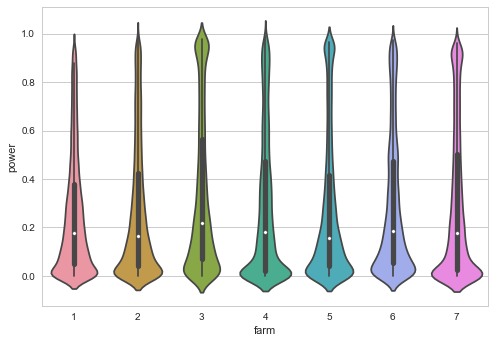

In [335]:
#sns.pairplot(whole_data.dropna())
colors = {1:'red', 48:'blue'}
accurate = whole_data#.loc[(whole_data.dist ==1) |(whole_data.farm==1)].dropna()
#accurate.boxplot('angle',by='farm')#.map({1:'red', 2:'blue'}))
sns.violinplot(x="farm", y="power", data=accurate)
plt.show()

Oddly, we are seeing some normalized values higher than 1 and some negaive power. We need to futher consider those in data cleaning.

### Last day point

We want to see what is the profile of the power 24 hours or 48 hours before the prediction. 

For example, assume we are predicting power for tomorrow at 3:00pm from today at 10:00 pm. If we can go back 7 hours, we will have one day difference with the predicted value.

In [336]:
date_power = whole_data[['date','dist','power','farm']]

In [337]:
farm_date_power = whole_data[['date','farm','power']]

In [338]:
date_power['last_day'] = date_power.dist.apply(lambda x: 24 if 0<x<24 else 48)
date_power.head()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,dist,power,farm,last_day
0,2009-07-01 01:00:00,1,0.085,1,24
1,2009-07-01 02:00:00,2,0.020,1,24
2,2009-07-01 03:00:00,3,0.060,1,24
3,2009-07-01 04:00:00,4,0.045,1,24
4,2009-07-01 05:00:00,5,0.035,1,24


In [339]:
date_power['date_last_day'] = date_power.date - pd.to_timedelta(date_power['last_day'], unit='h')
date_power.head()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,dist,power,farm,last_day,date_last_day
0,2009-07-01 01:00:00,1,0.085,1,24,2009-06-30 01:00:00
1,2009-07-01 02:00:00,2,0.020,1,24,2009-06-30 02:00:00
2,2009-07-01 03:00:00,3,0.060,1,24,2009-06-30 03:00:00
3,2009-07-01 04:00:00,4,0.045,1,24,2009-06-30 04:00:00
4,2009-07-01 05:00:00,5,0.035,1,24,2009-06-30 05:00:00


In [340]:
date_power_1 = date_power.merge(farm_date_power, left_on =['date_last_day','farm'], right_on =['date','farm'], how = 'left', suffixes=['','last_day'] )
date_power_1.head()

,date,dist,power,farm,last_day,date_last_day,datelast_day,powerlast_day
0,2009-07-01 01:00:00,1,0.085,1,24,2009-06-30 01:00:00,NaT,NaN
1,2009-07-01 02:00:00,2,0.020,1,24,2009-06-30 02:00:00,NaT,NaN
2,2009-07-01 03:00:00,3,0.060,1,24,2009-06-30 03:00:00,NaT,NaN
3,2009-07-01 04:00:00,4,0.045,1,24,2009-06-30 04:00:00,NaT,NaN
4,2009-07-01 05:00:00,5,0.035,1,24,2009-06-30 05:00:00,NaT,NaN


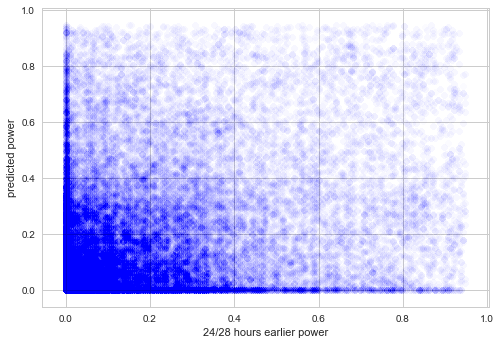

In [341]:
plt.scatter(date_power_1.loc[date_power_1.farm==1].powerlast_day,
            date_power_1.loc[date_power_1.farm==1].power, color = 'blue',
           alpha = 0.005)
plt.xlabel('24/28 hours earlier power')
plt.ylabel('predicted power')
plt.show()

In [342]:
date_power_1.loc[date_power_1.farm==1].powerlast_day.corr(date_power_1.loc[date_power_1.farm==1].power)

0.19898164793229473

### Last three hours profile

We want to see what is the profile of the power for the last 3 hours before each prediction. We like to get the moving average of the previous 3 hours power at the point of prediction. We will see that around $10\%$ of the variance is explained through this variable which makes it acceptable to be included in the feature_set.

In [343]:
power_each_farm = pd.read_csv('train.csv') #getting the power for each farm
power_each_farm.date = pd.to_datetime(power_each_farm.date, format='%Y%m%d%H', errors='ignore')
power_each_farm.set_index('date', inplace=True)
power_each_farm_smoothed = power_each_farm.rolling(window=3).mean()
power_each_farm_smoothed.fillna(method='bfill',inplace=True)

In [344]:
profile_power = pd.melt(frame = power_each_farm_smoothed.reset_index(), id_vars =['date'] ,value_vars =['wp1','wp2','wp3','wp4','wp5','wp6','wp7'], var_name = 'farm', value_name='power_profile' )
profile_power.farm = profile_power.farm.apply(lambda x: int(x[2:]))

In [345]:
profile_power.rename(columns={"date": "start"},inplace=True)
profile_power.head()

,start,farm,power_profile
0,2009-07-01 00:00:00,1,0.050000
1,2009-07-01 01:00:00,1,0.050000
2,2009-07-01 02:00:00,1,0.050000
3,2009-07-01 03:00:00,1,0.055000
4,2009-07-01 04:00:00,1,0.041667


In [346]:
whole_data = whole_data.merge(profile_power, how='left', left_on = ['start','farm'], right_on = ['start','farm'])

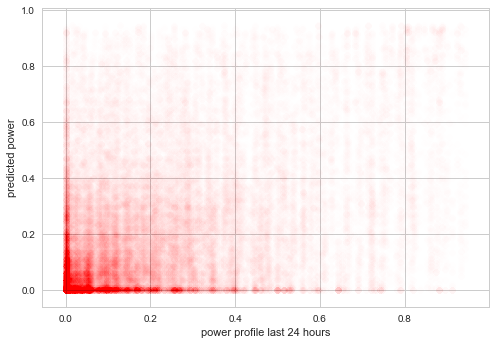

In [347]:
plt.scatter(whole_data.loc[whole_data.farm==1].power_profile,
            whole_data.loc[whole_data.farm==1].power, color = 'red',
           alpha = 0.005)
plt.xlabel('power profile past 3 hours')
plt.ylabel('predicted power')
plt.show()

In [348]:
whole_data.loc[whole_data.farm==1].power_profile.corr(whole_data.loc[whole_data.farm==1].power)

0.3405988748811246

Let's also include the last day feature to our feature set.

In [356]:
whole_data = whole_data.merge(date_power_1[['date','farm','powerlast_day']], on = ['date','farm'], how='left')
whole_data.head()

,date,start,dist,u,v,ws,wd,farm,turn,angle,wd_cut,w3p,set,hour,month,year,power,power_profile,powerlast_day
0,2009-07-01 01:00:00,2009-07-01,1,2.34,-0.79,2.47,108.68,1,00,-58.606518,"(90.012, 135.009]",15.069223,1,01,07,2009,0.085,0.05,NaN
1,2009-07-01 02:00:00,2009-07-01,2,2.18,-0.99,2.40,114.31,1,00,-76.730730,"(90.012, 135.009]",13.824000,1,02,07,2009,0.020,0.05,NaN
2,2009-07-01 03:00:00,2009-07-01,3,2.20,-1.21,2.51,118.71,1,00,-90.511778,"(90.012, 135.009]",15.813251,1,03,07,2009,0.060,0.05,NaN
3,2009-07-01 04:00:00,2009-07-01,4,2.35,-1.40,2.73,120.86,1,00,-96.711249,"(90.012, 135.009]",20.346417,1,04,07,2009,0.045,0.05,NaN
4,2009-07-01 05:00:00,2009-07-01,5,2.53,-1.47,2.93,120.13,1,00,-94.743438,"(90.012, 135.009]",25.153757,1,05,07,2009,0.035,0.05,NaN


### EDA on wind speed and wind direction:

Before finalizing the train/test set, let's take a look out the information we might bea belt to get from the wind speed/wind direction.

In [377]:
wind_list = ['date','dist', 'u','v','ws','wd','farm','w3p', 'wd_cut', 'power']
wind = whole_data[wind_list]
wind.head()

,date,dist,u,v,ws,wd,farm,w3p,wd_cut,power
0,2009-07-01 01:00:00,1,2.34,-0.79,2.47,108.68,1,15.069223,"(90.012, 135.009]",0.085
1,2009-07-01 02:00:00,2,2.18,-0.99,2.40,114.31,1,13.824000,"(90.012, 135.009]",0.020
2,2009-07-01 03:00:00,3,2.20,-1.21,2.51,118.71,1,15.813251,"(90.012, 135.009]",0.060
3,2009-07-01 04:00:00,4,2.35,-1.40,2.73,120.86,1,20.346417,"(90.012, 135.009]",0.045
4,2009-07-01 05:00:00,5,2.53,-1.47,2.93,120.13,1,25.153757,"(90.012, 135.009]",0.035


We know that the zonal(``u``) and meridional(``v``) components are directly connected to the wind speed (``ws``) and wind direction (``wd``). Let's study that and see if we can potentially drop a few redundunt features.. 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


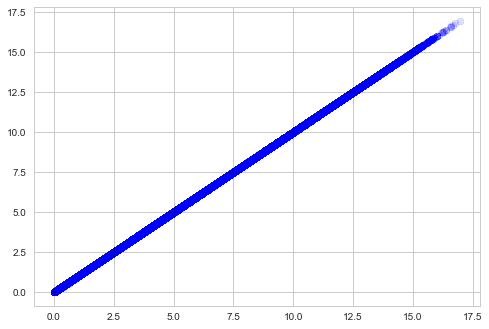

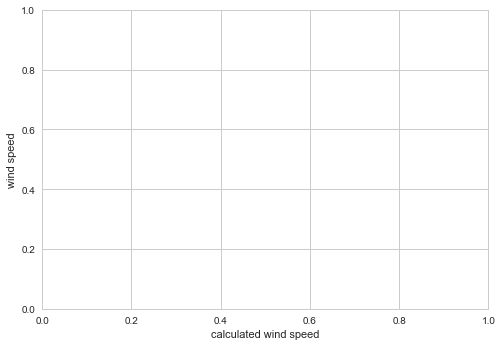

In [368]:
wind['calculated_ws'] = np.sqrt(wind.u**2+wind.v**2)
plt.scatter(wind.calculated_ws, wind.ws, alpha= 0.009, color = 'blue')
plt.show()
plt.xlabel('calculated wind speed')
plt.ylabel('wind speed')
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


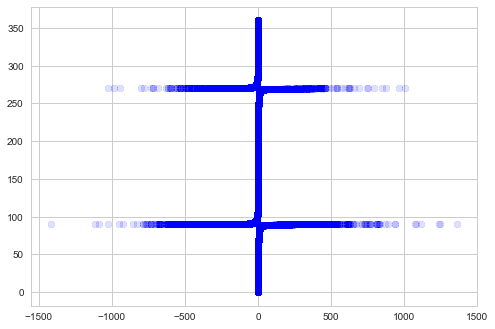

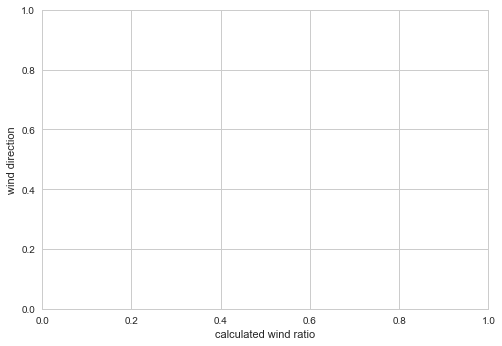

In [370]:
wind['calculated_ratio'] = (wind.u/wind.v)
plt.scatter(wind.calculated_ratio, wind.wd, alpha= 0.009, color = 'red')
plt.show()
plt.xlabel('calculated wind ratio')
plt.ylabel('wind direction')
plt.show()

We see a tangetic relationship between calculated ratio and wind direction. Therefore, these two set of data (``ws, wd`` and ``u, v``) are redundunt. We need to see which one provides more information. The most intuitive feature is the wind speed. Let's analyse that. We will get a random sample of the data set to perform our calculations faster.

In [418]:
data_sample = wind.sample(100000)

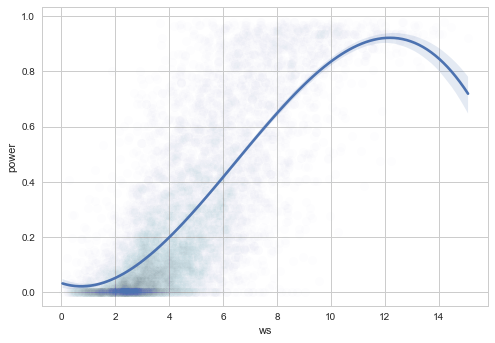

In [381]:
sns.regplot(x="ws", y="power", data=data_sample,
scatter_kws={"s": 80, "alpha":0.009},order=3,truncate=True)
plt.show()

We know that wind speed has a third order relationship with wind power generated from the wind farms.
This is also evident from the above relationship. Let's create a feature from cube of wind speed and wind power.

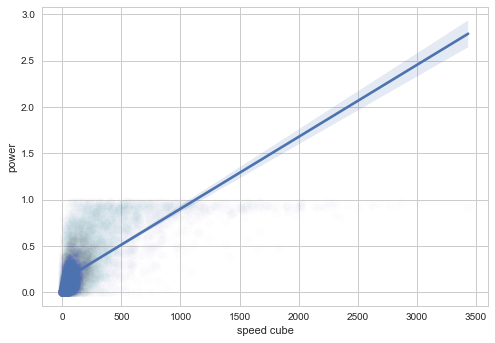

In [387]:
data_sample['speed_cube'] = data_sample['ws']**3
sns.regplot(x="speed_cube", y="power", data=data_sample,
scatter_kws={"s": 80, "alpha":0.009},truncate=True, robust=True)
plt.xlabel('speed cube')
plt.ylabel('power')
plt.show()

In [391]:
data_sample.speed_cube.corr(data_sample.power)**2

0.4283184952865767

We see that $43\%$ of the variance is explained by wind speed cube. This is very good. An observation is that, the wind turbine has some limitations, and even in very high speed, it might no generate more than its rating power. Moreover, the correlation has low uncertainty below 10m/s. For that, lets create a new feature (below_10) to capture this uncertainty.

Another observation is that sometimes in smaller speeds, the 

In [393]:
data_sample['below_10'] = data_sample.ws < 10

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


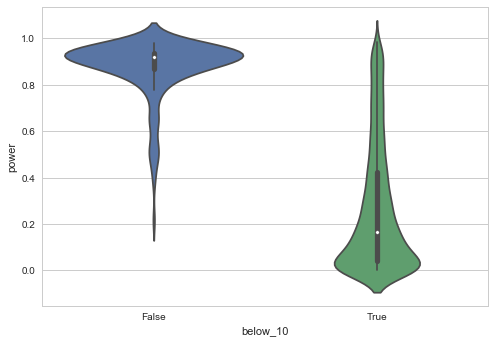

In [395]:
sns.violinplot(x="below_10", y="power", data=data_sample)
plt.show()

They are visually from different populations and we can use them in our classification. However, if we are using tree based regressors, there is not need for such categorization.

Another observation from power/speed_cube figure is that for some lower speed (<8m/s), the generated power reaches the rating power (0.8<power<1). This might be the results of forecasting error, or the wind direction. Let's get a boolean mask from this data and check the wind direction to see if it eefects it.

In [456]:
data_sample['high_power'] = (data_sample.ws<7) & (0.9<data_sample.power) & (data_sample.farm ==2)

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


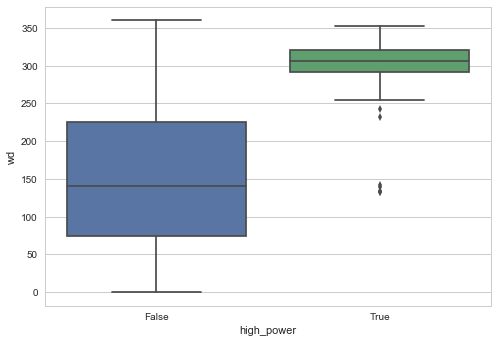

In [457]:
sns.boxplot(x="high_power", y="wd", data=data_sample.dropna())
plt.show()

We can further visualize the effect of wind direction, by keeping the wind speed almost constant and see the effect of wind direction on power. Before that, we need to visualize what wind speeds are dominant in each location. 

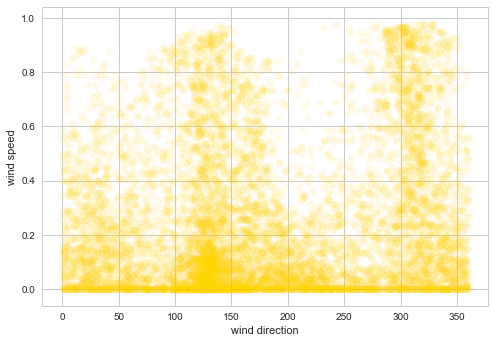

In [458]:
BM_const_power = (data_sample.farm ==2)
data_cons_power = data_sample.loc[BM_const_power,['wd','power']]
plt.scatter(data_cons_power.wd, data_cons_power.power, color='gold',alpha=0.08)
plt.xlabel('wind direction')
plt.ylabel('wind speed')
plt.show()

There seems to be three dominant wind directions, one around 20 degrees, the other around 120 decrees and last one aroun 330 degrees. Let's see, if we keep the effect of wind speed close to constant, how wind direction effect the wind power.From the figure we can see that in general, the wind direction of 330 degrees is stronger than the other two dominant speeds.

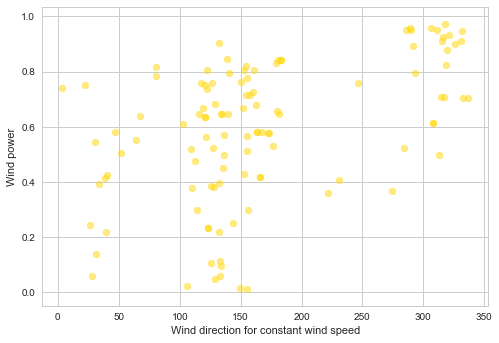

In [459]:
BM_const_power = (data_sample.farm ==2) &(data_sample.ws<7) &(data_sample.ws>6.8)
data_cons_power = data_sample.loc[BM_const_power,['wd','power']]
plt.scatter(data_cons_power.wd, data_cons_power.power, color='gold',alpha=0.5)
plt.xlabel('Wind direction for constant wind speed')
plt.ylabel('Wind power')
plt.show()

The wind direction has an obvios relationship with whether the power is too high. Therefore, we can exclude such information. For that, we need to get the median of the wind direction for each farm and calculated the difference away from that value. Another point, is that foreach farm, this value is differet (as probably each farm is located in different direction).

In [444]:
def angle_diff(angle):
    angle = angle % 360
    if angle <180:
        return angle
    else:
        return angle-180

In [461]:
farm_dominant = dict()

for farm in range(1,8):
    boolean_mask = (data_sample.ws<7) & (0.9<data_sample.power) & (data_sample.farm ==farm)
    series = data_sample.loc[boolean_mask].wd
    farm_dominant[farm]= series.median()

print(farm_dominant)

{1: 176.12, 2: 305.96, 3: 60.685, 4: 85.325, 5: 50.295, 6: 49.65, 7: 86.56}


In [472]:
data_sample['angle_diff'] = (data_sample.farm.replace(farm_dominant)-data_sample.wd).apply(angle_diff)

In [473]:
data_sample.head()

,date,dist,u,v,ws,wd,farm,w3p,wd_cut,power,high_power,angle_diff
4746866,2011-12-30 01:00:00,25,0.79,3.78,3.86,11.77,3,57.512456,"(-0.35, 45.009]",0.553,False,48.915
9614940,2011-09-19 10:00:00,22,-3.87,5.92,7.07,326.81,6,353.393243,"(315.0, 360.0]",0.526,False,82.840
8793906,2010-04-02 20:00:00,20,1.43,7.99,8.12,10.17,6,535.387328,"(-0.36, 45.0]",0.632,False,39.480
10133214,2009-08-27 23:00:00,35,-1.33,-3.19,3.45,202.56,7,41.063625,"(180.0, 225.0]",0.000,False,64.000
9398081,2011-04-30 17:00:00,5,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,False,NaN


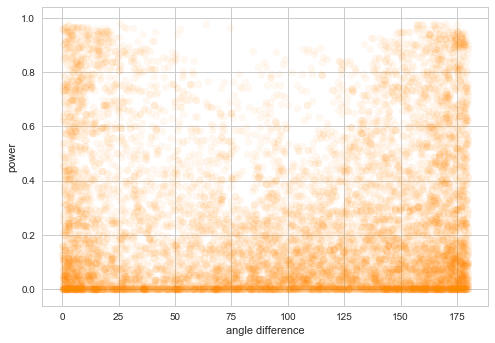

In [480]:
plt.scatter(data_sample.loc[data_sample.farm==2,'angle_diff' ],data_sample.loc[data_sample.farm==2,'power' ], color='darkorange',alpha=0.055)
plt.xlabel('angle difference')
plt.ylabel('power')
plt.show()

In [481]:
data_sample.loc[data_sample.farm==2,'angle_diff' ].corr(data_sample.loc[data_sample.farm==2,'power' ])

0.004455711927906928

After this calculation, we see that not a lot information is available inside wind direction. We wil put our focus on wind speed, its square, and its cube.

### Feature cleaning and data modelling:

After doing a thorough analysis of the data and extracting meaningful features, let's clean the model and train a regressor.

In [491]:
whole_data.columns.values

array(['date', 'start', 'dist', 'u', 'v', 'ws', 'wd', 'farm', 'turn',
       'angle', 'wd_cut', 'w3p', 'set', 'hour', 'month', 'year', 'power',
       'power_profile', 'powerlast_day'], dtype=object)

In [493]:
whole_data['ws2']= whole_data.ws ** 2
whole_data['ws3'] = whole_data.ws ** 3
whole_data.columns.values

array(['date', 'start', 'dist', 'u', 'v', 'ws', 'wd', 'farm', 'turn',
       'angle', 'wd_cut', 'w3p', 'set', 'hour', 'month', 'year', 'power',
       'power_profile', 'powerlast_day', 'ws2', 'ws3'], dtype=object)

In [494]:
whole_data = whole_data.drop(axis = 1, columns = ['date','start','dist','u','v','turn','angle','wd_cut','w3p','set'])
whole_data.head()

,ws,wd,farm,hour,month,year,power,power_profile,powerlast_day,ws2,ws3
0,2.47,108.68,1,01,07,2009,0.085,0.05,NaN,6.1009,15.069223
1,2.40,114.31,1,02,07,2009,0.020,0.05,NaN,5.7600,13.824000
2,2.51,118.71,1,03,07,2009,0.060,0.05,NaN,6.3001,15.813251
3,2.73,120.86,1,04,07,2009,0.045,0.05,NaN,7.4529,20.346417
4,2.93,120.13,1,05,07,2009,0.035,0.05,NaN,8.5849,25.153757


In [503]:
data = whole_data.loc[~whole_data.power.isnull(),:]
hold_out = whole_data.loc[whole_data.power.isnull(),:].drop(axis=1, columns='power')
print("Hold out size is {:.2f} of the training dataset".format(hold_out.shape[0]/data.shape[0]))

Hold out size is 0.40 of the training dataset


In [510]:
data.dropna(inplace=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Train test split

In [511]:
y = data.power
X = data.drop(axis=1, columns = 'power')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [513]:
neigh = KNeighborsRegressor()
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [515]:
print("Train R^2 is {}".format(neigh.score(X_train, y_train)))
print("Test R^2 is {}".format(neigh.score(X_test,y_test)))

Train adjuested R^2 is 0.9995534416607932
Test adjuested R^2 is 0.9986410280687853


The model shows remarkable accuracy. Let's further prove that using k-fold cross validation.

In [521]:
negh2 = KNeighborsRegressor()
scoring = ['explained_variance','r2', 'neg_mean_squared_error']
cv_results = cross_val_score(negh2, X, y, cv=5,scoring = 'explained_variance')
print(cv_results)

[0.13998346 0.35993115 0.38433055 0.3506495  0.43475853]


In [522]:
scoring = ['explained_variance','r2', 'neg_mean_squared_error']
cv_results = cross_val_score(negh2, X, y, cv=5,scoring = 'r2')
print(cv_results)

[0.13609758 0.35523629 0.38386206 0.34924181 0.3962556 ]


In [523]:
print(np.mean(cv_results))

0.32413866921353457


Using the available data sets, up to 33% of the total variance in the output power is explanied.
We need more information for explaining the rest of the variance.